In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn import preprocessing
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
dataset1=r'2.4.xlsx'
dataset=pd.read_excel(dataset1,engine='openpyxl')
dataset.head()

RM    CA V    FA V    W/S             E  Initial curing H  day  type  \
0  0.084  497.69  213.08  0.228  5.880000e+07                20    7     2   
1  0.154  497.69  213.08  0.209  1.400000e+06                20    7     2   
2  0.154  497.69  213.08  0.209  9.800000e+06                20    7     2   
3  0.154  497.69  213.08  0.209  1.820000e+07                20    7     2   
4  0.154  497.69  213.08  0.209  8.400000e+06                20    7     2   

     fc  
0  17.0  
1   8.0  
2  24.0  
3  37.0  
4  20.0

In [4]:
X = dataset.loc[:, dataset.columns != 'fc']
y = dataset.loc[:, 'fc']


(3390, 8)
(3390,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test_validation, y_train, y_test_validation = train_test_split(X, y, test_size=0.40, random_state=10)
X_test,X_validation,y_test,y_validation = train_test_split(X_test_validation, y_test_validation, test_size=0.50, random_state=10)

# Random forest

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

regr_1 = RandomForestRegressor(n_estimators=818, max_depth=24, max_leaf_nodes=550, min_samples_leaf=1, 
                               min_samples_split=6, bootstrap= False, random_state=0, max_features=3)

scores = cross_val_score (regr_1, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 7.314016346830471


In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 

def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / true)

regr_1.fit(X_train, y_train)

Z1 = regr_1.predict(X_train)
Z2 = regr_1.predict(X_test)
Z3 = regr_1.predict(X_validation)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))
print("Testing R2:", r2_score(y_validation, Z3), "RMSE:", np.sqrt(mean_squared_error(y_validation, Z3)),
      "MAE:", mean_absolute_error(y_validation, Z3), "MAPE:", MAPE(y_validation, Z3))

Training R2: 0.96108443046602 RMSE: 3.109824839673831 MAE: 2.13515680234134 MAPE: 0.08915165020394616
Testing R2: 0.7866994085134894 RMSE: 7.61856958963398 MAE: 5.02562204102446 MAPE: inf
Testing R2: 0.8250787472096743 RMSE: 6.5412240960018675 MAE: 4.429286095027124 MAPE: inf


In [9]:
RF_r2,RF_RMSE,RF_MAE,RF_MAPE=[],[],[],[]
RF_r2.append(r2_score(y_train, Z1))
RF_r2.append(r2_score(y_test, Z2))
RF_r2.append(r2_score(y_validation, Z3))
RF_RMSE.append(np.sqrt(mean_squared_error(y_train, Z1)))
RF_RMSE.append(np.sqrt(mean_squared_error(y_test, Z2)))
RF_RMSE.append(np.sqrt(mean_squared_error(y_validation, Z3)))
RF_MAE.append(mean_absolute_error(y_train, Z1))
RF_MAE.append(mean_absolute_error(y_test, Z2))
RF_MAE.append(mean_absolute_error(y_validation, Z3))

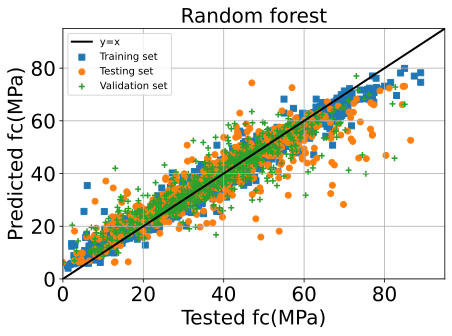

In [10]:
import matplotlib.pyplot as plt

xx = np.linspace(0, 100, 10)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')
plt.scatter(y_validation, Z3, marker='+')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set','Validation set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested fc(MPa)', fontsize=20)
plt.ylabel('Predicted fc(MPa)', fontsize=20)
plt.xlim([0, 95])
plt.ylim([0, 95])
plt.title('Random forest', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('R4.svg',dpi=300,bbox_inches="tight")
plt.show()

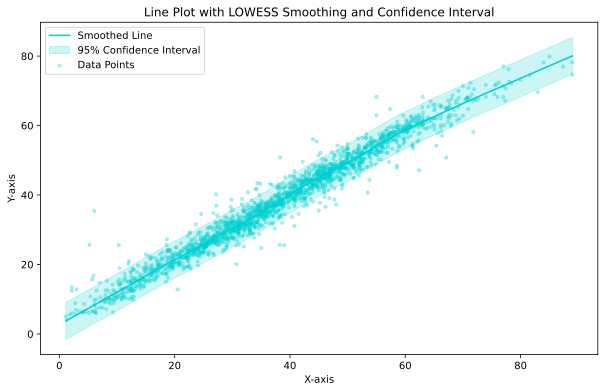

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_train, 'y': Z1})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z1, y_train, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z1 - np.interp(y_train, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#00CED1')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#00CED1', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_train, Z1, color='#00CED1', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('R41.svg',dpi=300,bbox_inches="tight")
plt.show()

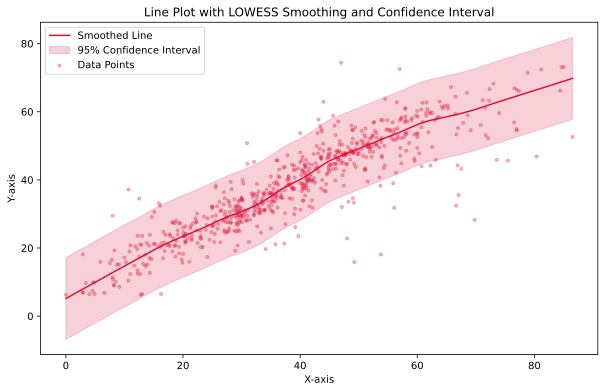

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_test, 'y': Z2})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z2, y_test, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z2 - np.interp(y_test, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#DC143C')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#DC143C', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_test, Z2, color='#DC143C', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('R42.svg',dpi=300,bbox_inches="tight")
plt.show()

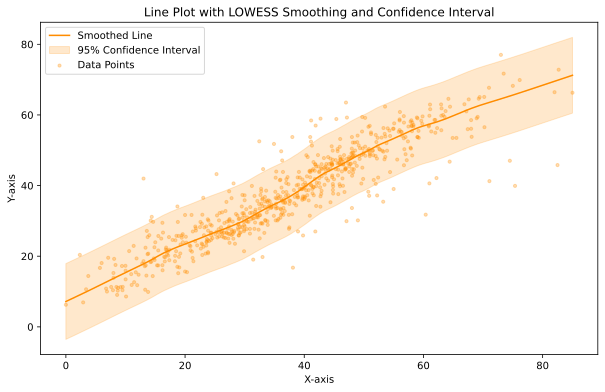

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_validation, 'y': Z3})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z3, y_validation, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z3 - np.interp(y_validation, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#FF8C00')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#FF8C00', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_validation, Z3, color='#FF8C00', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('R43.svg',dpi=300,bbox_inches="tight")
plt.show()

# AdaBoost

In [15]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

regr_2 = AdaBoostRegressor (tree.DecisionTreeRegressor(max_depth=20, min_samples_split=2, min_samples_leaf=3,
                                                       max_leaf_nodes=260, criterion='squared_error'),
                            n_estimators=285, learning_rate=0.1, random_state=0)


scores = cross_val_score (regr_2, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 7.679482193129933


In [16]:
regr_2.fit(X_train, y_train)

Z1 = regr_2.predict(X_train)
Z2 = regr_2.predict(X_test)
Z3 = regr_2.predict(X_validation)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))
print("Testing R2:", r2_score(y_validation, Z3), "RMSE:", np.sqrt(mean_squared_error(y_validation, Z3)),
      "MAE:", mean_absolute_error(y_validation, Z3), "MAPE:", MAPE(y_validation, Z3))

Training R2: 0.951739033586346 RMSE: 3.4631574741212203 MAE: 2.8078518823441008 MAPE: 0.11393991084393403
Testing R2: 0.7794256819459882 RMSE: 7.747380418001601 MAE: 5.309742329031308 MAPE: inf
Testing R2: 0.8030469949696158 RMSE: 6.940952048333755 MAE: 4.80292732675925 MAPE: inf


In [17]:
AdaBoost_r2,AdaBoost_RMSE,AdaBoost_MAE,AdaBoost_MAPE=[],[],[],[]
AdaBoost_r2.append(r2_score(y_train, Z1))
AdaBoost_r2.append(r2_score(y_test, Z2))
AdaBoost_r2.append(r2_score(y_validation, Z3))
AdaBoost_RMSE.append(np.sqrt(mean_squared_error(y_train, Z1)))
AdaBoost_RMSE.append(np.sqrt(mean_squared_error(y_test, Z2)))
AdaBoost_RMSE.append(np.sqrt(mean_squared_error(y_validation, Z3)))
AdaBoost_MAE.append(mean_absolute_error(y_train, Z1))
AdaBoost_MAE.append(mean_absolute_error(y_test, Z2))
AdaBoost_MAE.append(mean_absolute_error(y_validation, Z3))

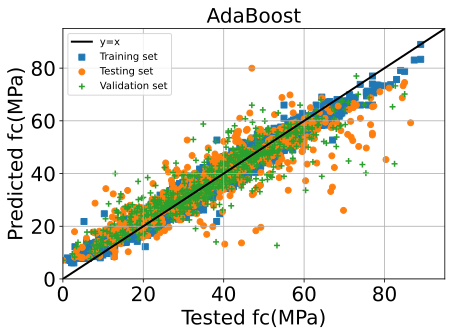

In [18]:
xx = np.linspace(0, 100, 10)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')
plt.scatter(y_validation, Z3, marker='+')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set','Validation set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested fc(MPa)', fontsize=20)
plt.ylabel('Predicted fc(MPa)', fontsize=20)
plt.xlim([0, 95])
plt.ylim([0, 95])
plt.title('AdaBoost', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('A4.svg',dpi=300,bbox_inches="tight")
plt.show()

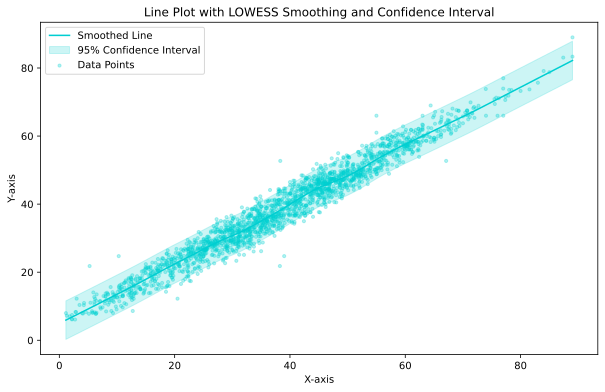

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_train, 'y': Z1})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z1, y_train, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z1 - np.interp(y_train, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#00CED1')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#00CED1', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_train, Z1, color='#00CED1', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('A41.svg',dpi=300,bbox_inches="tight")
plt.show()

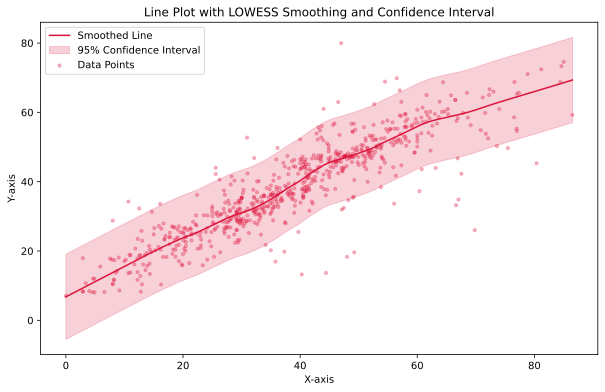

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_test, 'y': Z2})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z2, y_test, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z2 - np.interp(y_test, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#DC143C')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#DC143C', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_test, Z2, color='#DC143C', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()


# 显示图形
plt.savefig('A42.svg',dpi=300,bbox_inches="tight")
plt.show()

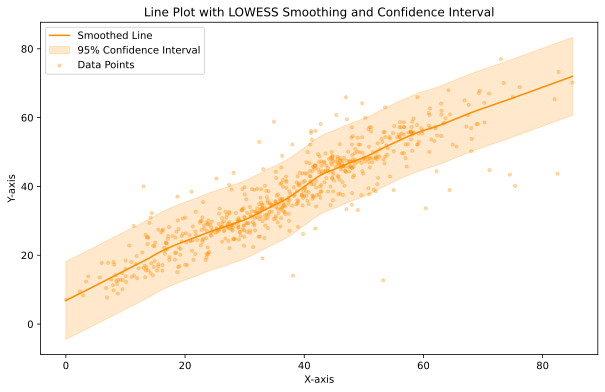

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_validation, 'y': Z3})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z3, y_validation, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z3 - np.interp(y_validation, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#FF8C00')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#FF8C00', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_validation, Z3, color='#FF8C00', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()


# 显示图形
plt.savefig('A43.svg',dpi=300,bbox_inches="tight")
plt.show()

# GBRT

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

regr_3 = GradientBoostingRegressor(n_estimators=355, learning_rate=0.16, max_depth=57, min_samples_leaf=7,
                                   min_samples_split=2, random_state=0, loss='squared_error')

scores = cross_val_score (regr_3, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 7.147508217160555


In [23]:
regr_3.fit(X_train, y_train)

Z1 = regr_3.predict(X_train)
Z2 = regr_3.predict(X_test)
Z3 = regr_3.predict(X_validation)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))
print("Testing R2:", r2_score(y_validation, Z3), "RMSE:", np.sqrt(mean_squared_error(y_validation, Z3)),
      "MAE:", mean_absolute_error(y_validation, Z3), "MAPE:", MAPE(y_validation, Z3))

Training R2: 0.9943666928702564 RMSE: 1.1831939699387346 MAE: 0.27422485533300456 MAPE: 0.011058766160478132
Testing R2: 0.7852588354769744 RMSE: 7.644253150702964 MAE: 4.619211823830469 MAPE: inf
Testing R2: 0.8117027659068788 RMSE: 6.786716512525706 MAE: 4.214234052589046 MAPE: inf


In [24]:
GBRT_r2,GBRT_RMSE,GBRT_MAE,GBRT_MAPE=[],[],[],[]
GBRT_r2.append(r2_score(y_train, Z1))
GBRT_r2.append(r2_score(y_test, Z2))
GBRT_r2.append(r2_score(y_validation, Z3))
GBRT_RMSE.append(np.sqrt(mean_squared_error(y_train, Z1)))
GBRT_RMSE.append(np.sqrt(mean_squared_error(y_test, Z2)))
GBRT_RMSE.append(np.sqrt(mean_squared_error(y_validation, Z3)))
GBRT_MAE.append(mean_absolute_error(y_train, Z1))
GBRT_MAE.append(mean_absolute_error(y_test, Z2))
GBRT_MAE.append(mean_absolute_error(y_validation, Z3))

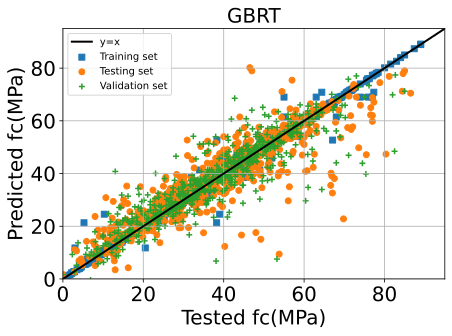

In [25]:
xx = np.linspace(0, 100, 10)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')
plt.scatter(y_validation, Z3, marker='+')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set','Validation set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested fc(MPa)', fontsize=20)
plt.ylabel('Predicted fc(MPa)', fontsize=20)
plt.xlim([0, 95])
plt.ylim([0, 95])
plt.title('GBRT', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('G4.svg',dpi=300,bbox_inches="tight")
plt.show()

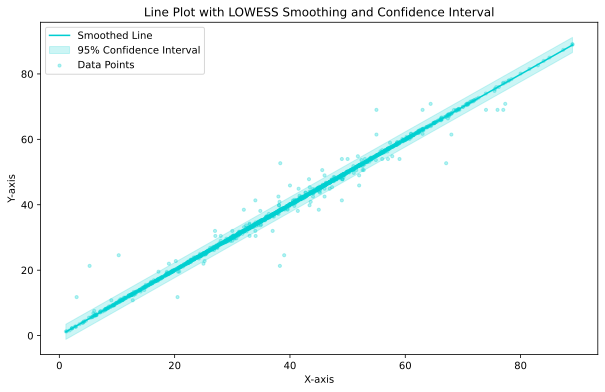

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_train, 'y': Z1})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z1, y_train, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z1 - np.interp(y_train, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#00CED1')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#00CED1', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_train, Z1, color='#00CED1', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('G41.svg',dpi=300,bbox_inches="tight")
plt.show()

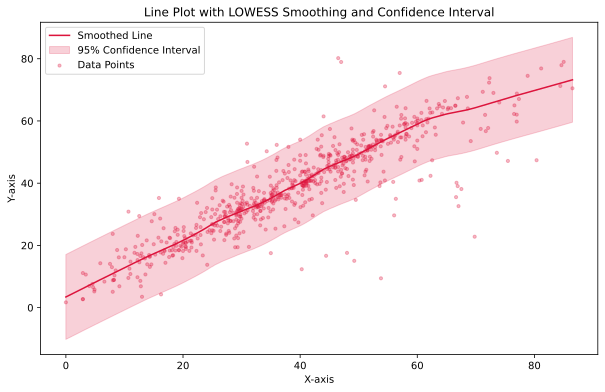

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_test, 'y': Z2})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z2, y_test, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z2 - np.interp(y_test, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#DC143C')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#DC143C', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_test, Z2, color='#DC143C', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('G42.svg',dpi=300,bbox_inches="tight")
plt.show()

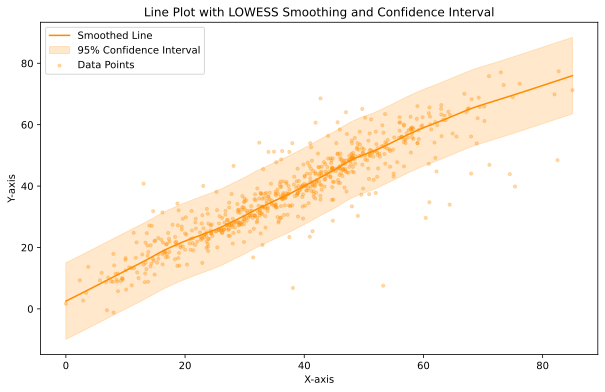

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_validation, 'y': Z3})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z3, y_validation, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z3 - np.interp(y_validation, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#FF8C00')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#FF8C00', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_validation, Z3, color='#FF8C00', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('G43.svg',dpi=300,bbox_inches="tight")
plt.show()

# XGBoost

In [29]:
regr_4 = xgb.XGBRegressor (max_depth=27, learning_rate=0.03, n_estimators=735, colsample_bytree=1, 
                           subsample=0.77, gamma=1, random_state=0)

scores = cross_val_score (regr_4, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 7.132945868124826


In [30]:
regr_4.fit(X_train, y_train)

Z1 = regr_4.predict(X_train)
Z2 = regr_4.predict(X_test)
Z3 = regr_4.predict(X_validation)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))
print("Testing R2:", r2_score(y_validation, Z3), "RMSE:", np.sqrt(mean_squared_error(y_validation, Z3)),
      "MAE:", mean_absolute_error(y_validation, Z3), "MAPE:", MAPE(y_validation, Z3))

Training R2: 0.9939261239871593 RMSE: 1.228590616251385 MAE: 0.5068068881723169 MAPE: 0.018752679136919564
Testing R2: 0.7968618054006227 RMSE: 7.434866985475169 MAE: 4.479294142246397 MAPE: inf
Testing R2: 0.8156603336643277 RMSE: 6.715017315202918 MAE: 4.069581187408694 MAPE: inf


In [31]:
XGBoost_r2,XGBoost_RMSE,XGBoost_MAE,XGBoost_MAPE=[],[],[],[]
XGBoost_r2.append(r2_score(y_train, Z1))
XGBoost_r2.append(r2_score(y_test, Z2))
XGBoost_r2.append(r2_score(y_validation, Z3))
XGBoost_RMSE.append(np.sqrt(mean_squared_error(y_train, Z1)))
XGBoost_RMSE.append(np.sqrt(mean_squared_error(y_test, Z2)))
XGBoost_RMSE.append(np.sqrt(mean_squared_error(y_validation, Z3)))
XGBoost_MAE.append(mean_absolute_error(y_train, Z1))
XGBoost_MAE.append(mean_absolute_error(y_test, Z2))
XGBoost_MAE.append(mean_absolute_error(y_validation, Z3))

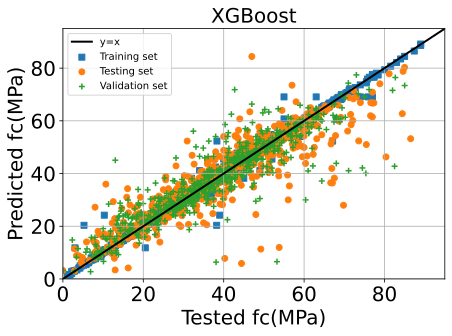

In [32]:
xx = np.linspace(0, 100, 10)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')
plt.scatter(y_validation, Z3, marker='+')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set','Validation set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested fc(MPa)', fontsize=20)
plt.ylabel('Predicted fc(MPa)', fontsize=20)
plt.xlim([0, 95])
plt.ylim([0, 95])
plt.title('XGBoost', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('X4.svg',dpi=300,bbox_inches="tight")
plt.show()

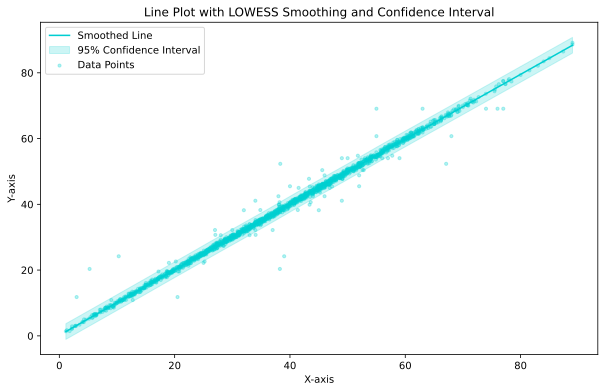

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_train, 'y': Z1})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z1, y_train, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z1 - np.interp(y_train, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#00CED1')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#00CED1', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_train, Z1, color='#00CED1', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('X41.svg',dpi=300,bbox_inches="tight")
plt.show()

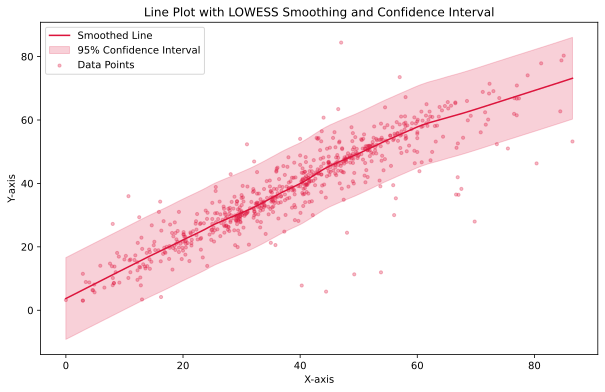

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_test, 'y': Z2})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z2, y_test, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z2 - np.interp(y_test, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#DC143C')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#DC143C', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_test, Z2, color='#DC143C', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('X42.svg',dpi=300,bbox_inches="tight")
plt.show()

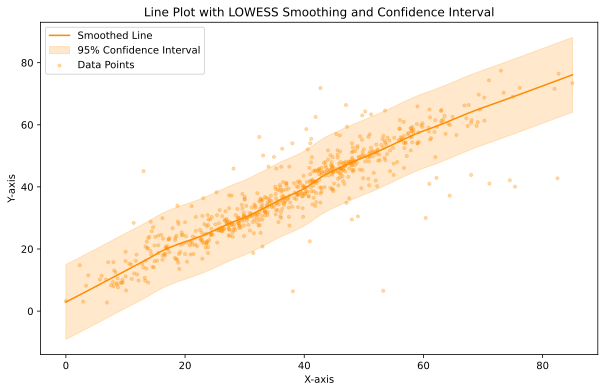

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
data = pd.DataFrame({'x': y_validation, 'y': Z3})

lowess = sm.nonparametric.lowess
smoothed = lowess(Z3, y_validation, frac=0.2)
x_smooth = smoothed[:, 0]
y_smooth = smoothed[:, 1]

residuals = Z3 - np.interp(y_validation, x_smooth, y_smooth)
std_error = np.std(residuals)
ci = 1.96 * std_error  # 95% 置信区间

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Smoothed Line', color='#FF8C00')
plt.fill_between(x_smooth, y_smooth - ci, y_smooth + ci, color='#FF8C00', alpha=0.2, label='95% Confidence Interval')
plt.scatter(y_validation, Z3, color='#FF8C00', s=10, alpha=0.3, label='Data Points', marker='o')

# 设置图形标题和标签
plt.title('Line Plot with LOWESS Smoothing and Confidence Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 显示图形
plt.savefig('X43.svg',dpi=300,bbox_inches="tight")
plt.show()

In [23]:
r2={'RF':RF_r2,'AdaBoost':AdaBoost_r2,'GBRT':GBRT_r2,'XGBoost':XGBoost_r2}
RMSE={'RF':RF_RMSE,'AdaBoost':AdaBoost_RMSE,'GBRT':GBRT_RMSE,'XGBoost':XGBoost_RMSE}
MAE={'RF':RF_MAE,'AdaBoost':AdaBoost_MAE,'GBRT':GBRT_MAE,'XGBoost':XGBoost_MAE}

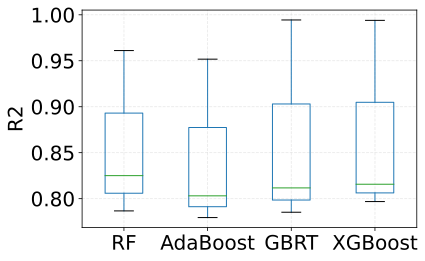

In [24]:
df_r2 = pd.DataFrame(r2)
df_r2.plot.box(fontsize=20)
plt.ylabel('R2', fontsize=20)
plt.grid(linestyle="--", alpha=0.3)
plt.savefig('C04.svg',dpi=300,bbox_inches="tight")
plt.show()

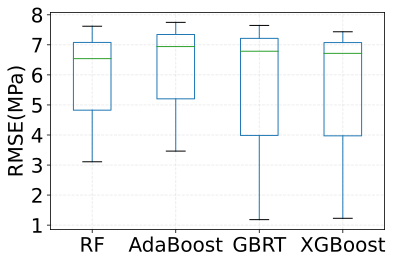

In [25]:
df_RMSE = pd.DataFrame(RMSE)
df_RMSE.plot.box(fontsize=20)
plt.ylabel('RMSE(MPa)', fontsize=20)
plt.grid(linestyle="--", alpha=0.3)
plt.savefig('C14.svg',dpi=300,bbox_inches="tight")
plt.show()

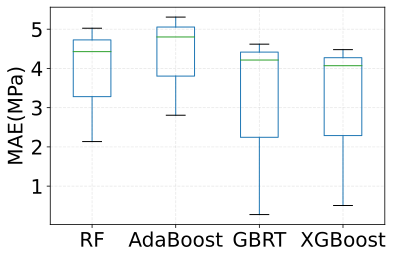

In [26]:
df_MAE = pd.DataFrame(MAE)
df_MAE.plot.box(fontsize=20)
plt.ylabel('MAE(MPa)', fontsize=20)
plt.grid(linestyle="--", alpha=0.3)
plt.savefig('C24.svg',dpi=300,bbox_inches="tight")
plt.show()